<a href="https://colab.research.google.com/github/MuhammadBasilKhan/Deep-learning-medical-classification/blob/main/face_gender_detection_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np

import os



In [ ]:
INIT_LR=1e-4
EPOCHS=20
BS=32
Directory='/content/gdrive/MyDrive/gender/Male and Female face dataset'
categories=['Female Faces','Male Faces']
data=[]
labels=[]

In [ ]:
for category in categories:
  path=os.path.join(Directory,category)
  for img in os.listdir(path):
    img_path=os.path.join(path,img)
    image=load_img(img_path,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image)
    data.append(image)
    labels.append(category)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data,dtype ="float32")
labels = np.array(labels)
(trainX,testX,trainY,testY) = train_test_split(data, labels,
                                               test_size=0.20, stratify=labels, random_state=42)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")


In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


INIT_LR = 0.001
EPOCHS = 10


lr_schedule = ExponentialDecay(initial_learning_rate=INIT_LR, decay_steps=10000, decay_rate=0.9)

opt = Adam(learning_rate=lr_schedule)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


In [ ]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/10
135/135 [==============================] - 256s 2s/step - loss: 0.3344 - accuracy: 0.8536 - val_loss: 0.1934 - val_accuracy: 0.9179
Epoch 2/10
135/135 [==============================] - 235s 2s/step - loss: 0.2270 - accuracy: 0.9056 - val_loss: 0.1639 - val_accuracy: 0.9373
Epoch 3/10
135/135 [==============================] - 242s 2s/step - loss: 0.1999 - accuracy: 0.9221 - val_loss: 0.1625 - val_accuracy: 0.9327
Epoch 4/10
135/135 [==============================] - 240s 2s/step - loss: 0.1878 - accuracy: 0.9240 - val_loss: 0.1442 - val_accuracy: 0.9391
Epoch 5/10
135/135 [==============================] - 242s 2s/step - loss: 0.1677 - accuracy: 0.9340 - val_loss: 0.1328 - val_accuracy: 0.9446
Epoch 6/10
135/135 [==============================] - 236s 2s/step - loss: 0.1632 - accuracy: 0.9414 - val_loss: 0.1540 - val_accuracy: 0.9354
Epoch 7/10
135/135 [==============================] - 235s 2s/step - loss: 0.1565 - accuracy: 0.9372 - val_loss: 0.123

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
34/34 [==============================] - 42s 1s/step


In [ ]:
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


              precision    recall  f1-score   support

Female Faces       0.99      0.92      0.96       540
  Male Faces       0.93      0.99      0.96       544

    accuracy                           0.96      1084
   macro avg       0.96      0.96      0.96      1084
weighted avg       0.96      0.96      0.96      1084



In [ ]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


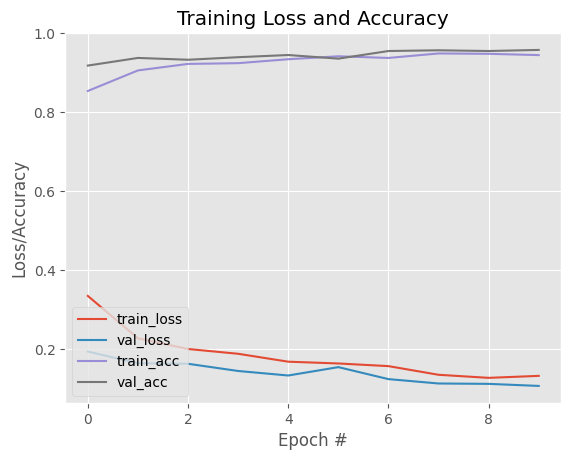

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")